# Understanding NanoGPT

GPT is decoder only transformers. 

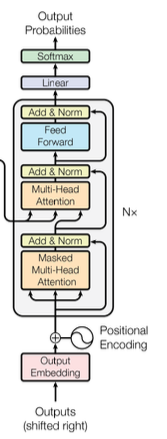

### Refs

1. https://bbycroft.net/llm

### Step 1 : Token and Positional embeddings

These embeddings are created during training. The size of embedding is vocab_size, d_model. d_model is the embedding dimension (e.g., 768 for GPT-2 small, 1600 for GPT-3).


### Step 2: Input for Decoders

Token and Positional Embedding are **added** to create input for decoder.

### Step 3: Layer Normalization

The first step is to normalize input matrix. This is done column wise.

- Normalization is an important step in the training of deep neural networks, and it helps improve the stability of the model during training.

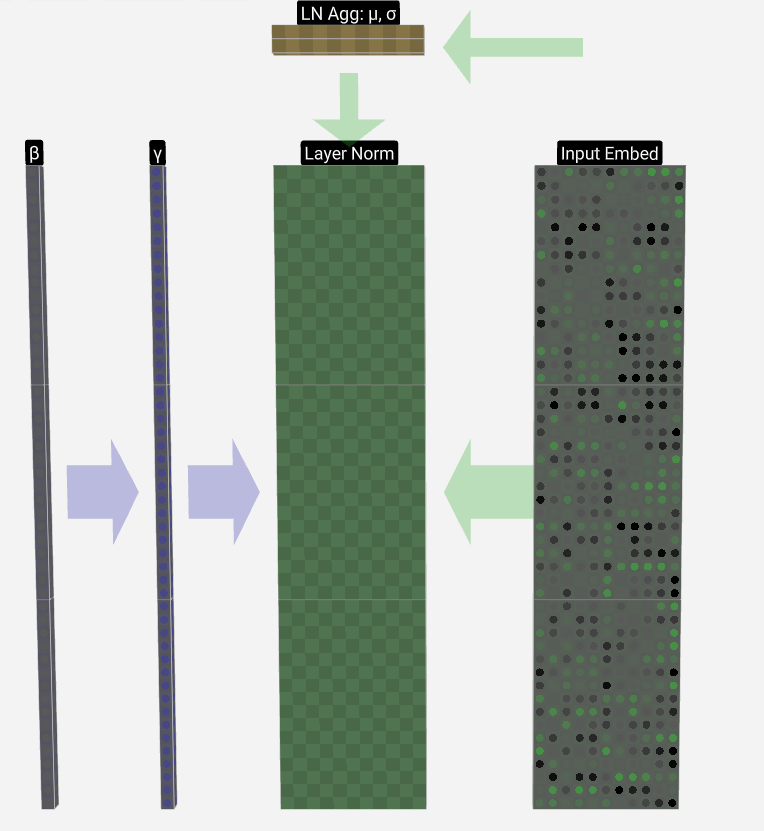

Layer normalization is applied as below

- calculate meand and standard devition and keep in a layer called 'Layer Normalization Agg'. Then apply these values to normalize each column

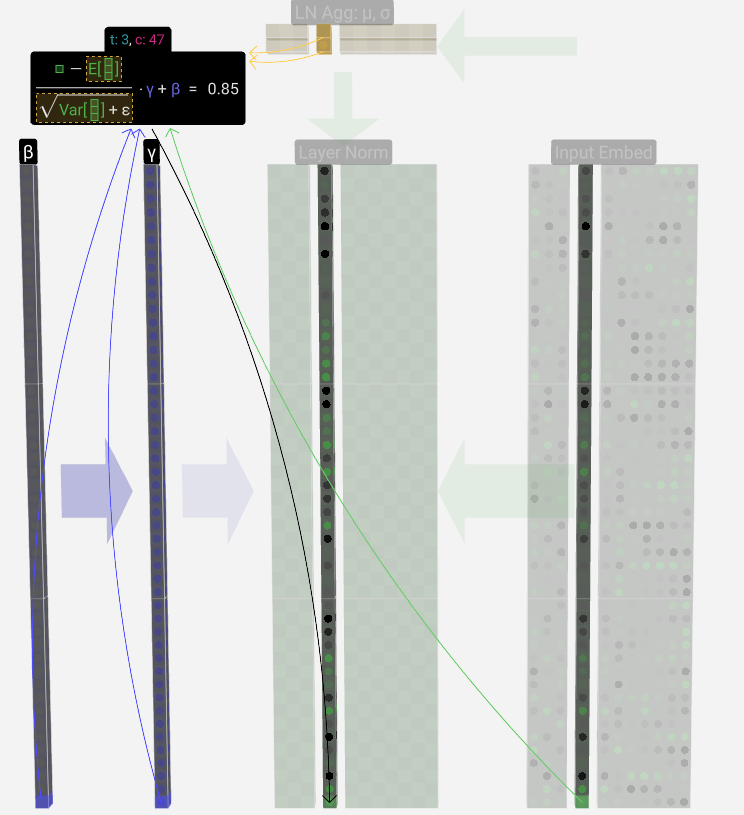

### Multi Head Self Attention

Self attention - The self-attention layer is perhaps the heart of the Transformer and of GPT.

It's the phase where the columns in our input embedding matrix "talk" to each other. Up until now, and in all other phases, the columns can be regarded independently.

The first step is to produce three vectors for each of the T columns from the normalized input embedding matrix. These vectors are the Q, K, and V vectors:

Q: Query vector

K: Key vector

V: Value vector

To produce one of these vectors, we perform a matrix-vector multiplication with a bias added. Each output cell is some linear combination of the input vector. E.g. for the Q vectors, this is done with a dot product between a row of the Q-weight matrix and a column of the input matrix.




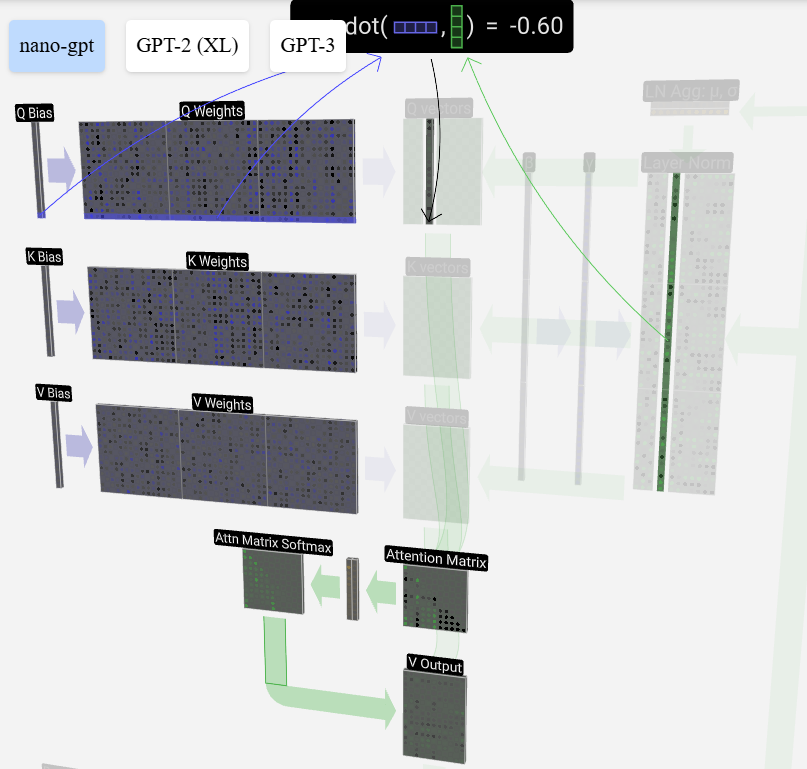

In the case of self-attention, instead of returning a single entry, we return some weighted combination of the entries. To find that weighting, we take a dot product between a Q vector and each of the K vectors. We normalize that weighting, before finally using it to multiply with the corresponding V vector, and then adding them all up.

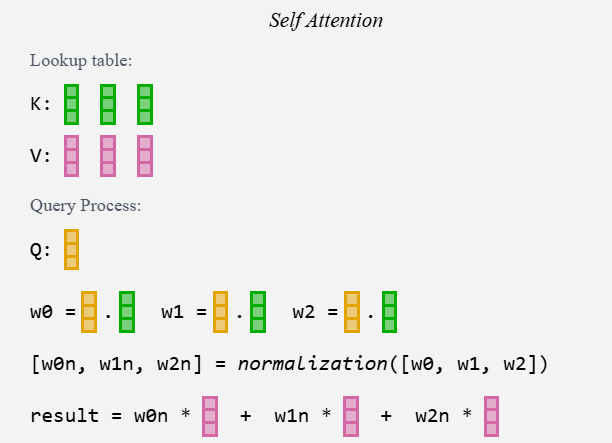

For a more concrete example, let's look at the 6th column (t = 5), from which we will query from:

The {K, V} entries of our lookup are the 6 columns in the past, and the Q value is the current time.

We first calculate the dot product between the Q vector of the current column (t = 5) and the K vectors of each of the those previous columns. These are then stored in the corresponding row (t = 5) of the attention matrix.

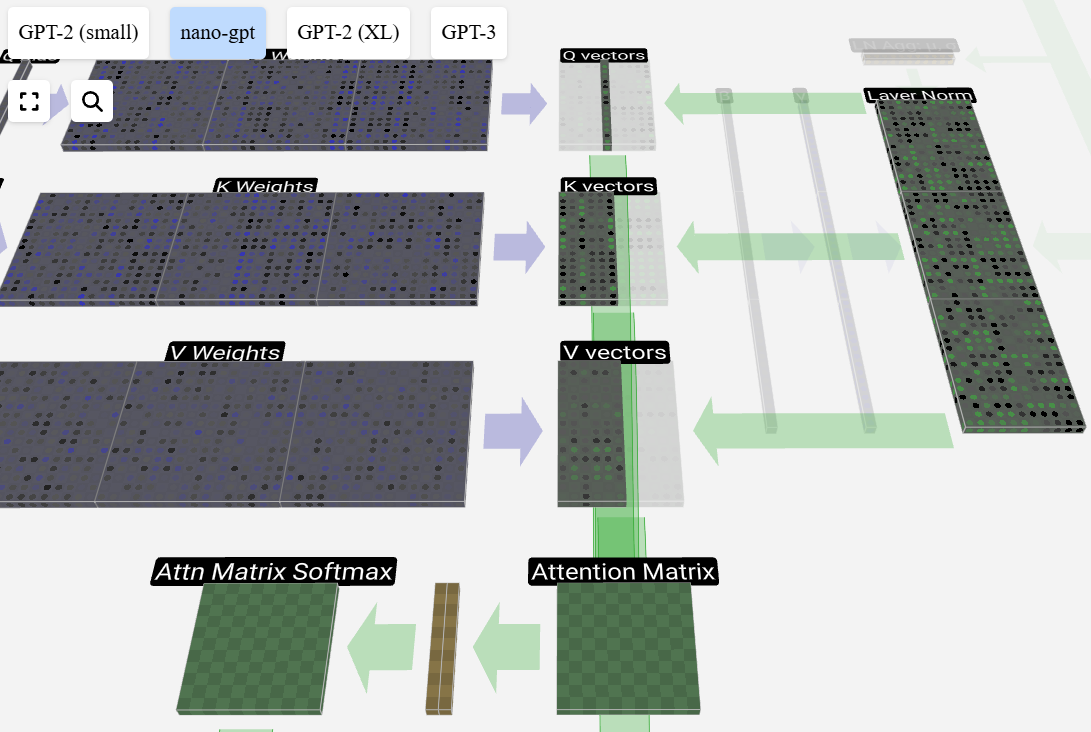

These dot products are a way of measuring the similarity between the two vectors. If they're very similar, the dot product will be large. If they're very different, the dot product will be small or negative.

The idea of only using the query against past keys makes this causal self-attention. That is, tokens can't "see into the future".

Another element is that after we take the dot product, we divide by sqrt(d), where d is the length of the Q/K/V vectors. This scaling is done to prevent large values from dominating the normalization (softmax) 

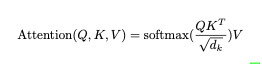

Finally, we can produce the output vector for our column (t = 5). We look at the (t = 5) row of the normalized self-attention matrix and for each element, multiply the corresponding V vector of the other columns element-wise.

Then we can add these up to produce the output vector. Thus, the output vector will be dominated by V vectors from columns that have high scores.

To combine the output vectors from each head, we simply stack them on top of each other. 

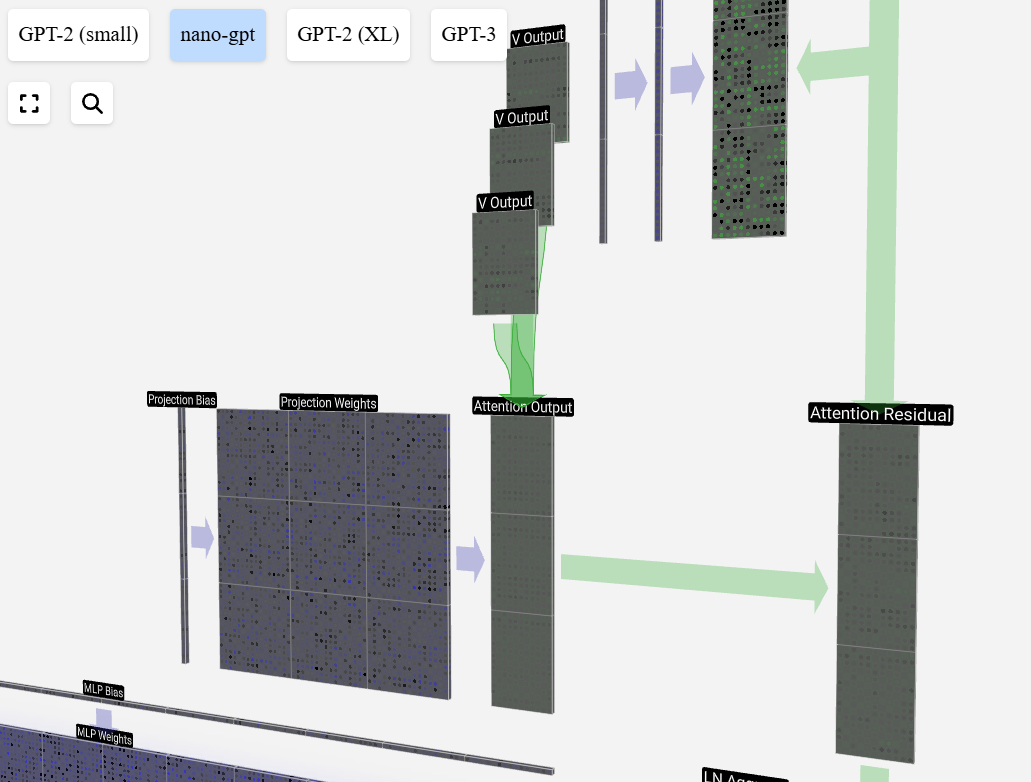

From here, we perform the projection to get the output of the layer. This is a simple matrix-vector multiplication on a per-column basis, with a bias added.

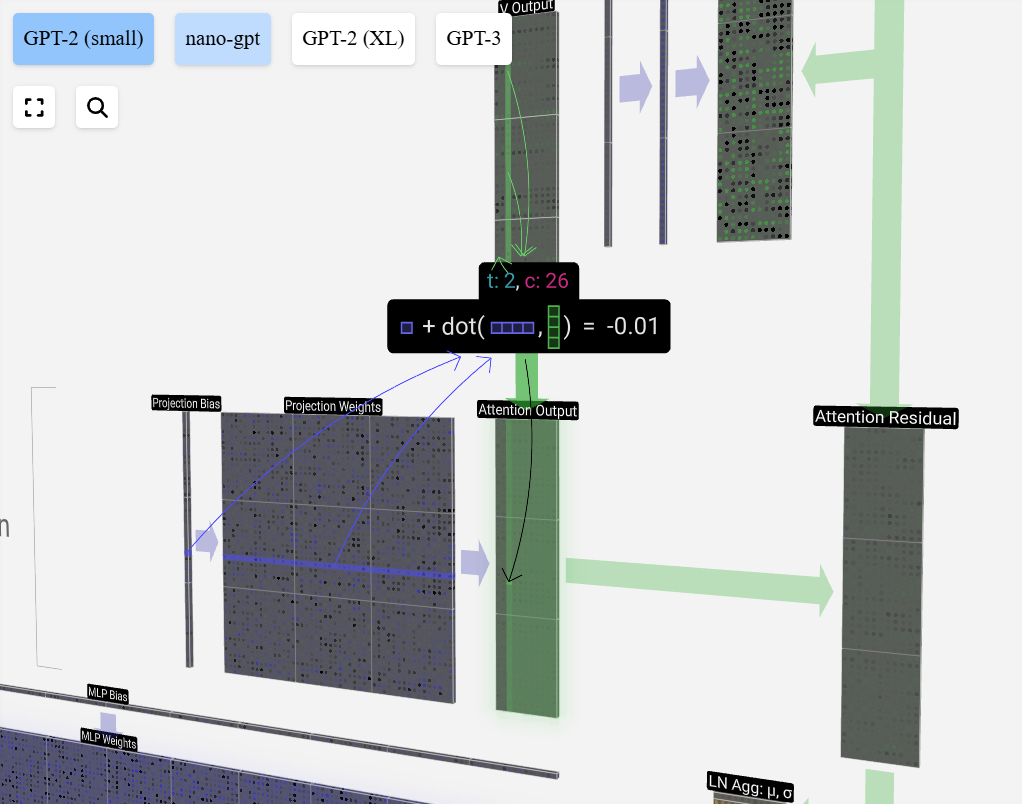

### Resudual Connection

Now we have the output of the self-attention layer. Instead of passing this output directly to the next phase, we add it element-wise to the input embedding. This process, denoted by the green vertical arrow, is called the residual connection or residual pathway.

Like layer normalization, the residual pathway is important for enabling effective learning in deep neural networks.





Now with the result of self-attention in hand, we can pass it onto the next section of the transformer: the feed-forward network.

## MLP

Like with self-attention, we perform a layer normalization before the vectors enter the MLP.

In the MLP, we put each of our C = 48 length column vectors (independently) through:

1. A linear transformation with a bias added, to a vector of length 4 * C.

2. A GELU activation function (element-wise)

3. A linear transformation with a bias added, back to a vector of length C

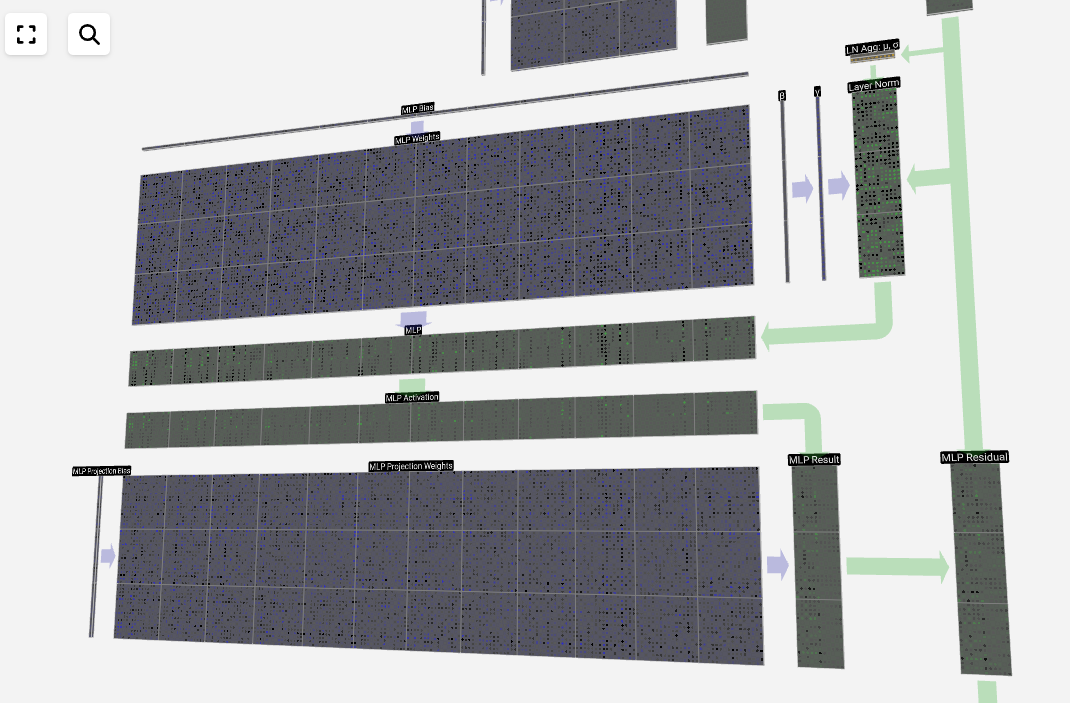

Next, we apply the GELU activation function to each element of the vector. This is a key part of any neural network, where we introduce some non-linearity into the model. The specific function used, GELU, looks a lot like a ReLU function (computed as max(0, x)), but it has a smooth curve rather than a sharp corner.

We then project the vector back down to length C with another matrix-vector multiplication with bias added.

Like in the self-attention + projection section, we add the result of the MLP to its input, element-wise.

## Transfomers

And that's a complete transformer block!

These form the bulk of any GPT model and are repeated a number of times, with the output of one block feeding into the next, continuing the residual pathway.

As is common in deep learning, it's hard to say exactly what each of these layers is doing, but we have some general ideas: the earlier layers tend to focus on learning lower-level features and patterns, while the later layers learn to recognize and understand higher-level abstractions and relationships. In the context of natural language processing, the lower layers might learn grammar, syntax, and simple word associations, while the higher layers might capture more complex semantic relationships, discourse structures, and context-dependent meaning.

## linear layer

The final decoder layer’s output is passed through a linear layer to project the d_model-dimensional embeddings to the vocabulary size, producing logits for each token in the sequence.
Use:

Maps the transformer’s output to a probability distribution over the vocabulary, enabling token prediction.
Essential for generating the next token in autoregressive tasks or computing probabilities for tasks like language modeling.

## softmax

What's with the name "softmax"? 

The "hard" version of this operation, called argmax, simply finds the maximum value, sets it to 1.0, and assigns 0.0 to all other values. 

In contrast, the softmax operation serves as a "softer" version of that. Due to the exponentiation involved in softmax, the largest value is emphasized and pushed towards 1.0, while still maintaining a probability distribution over all input values. This allows for a more nuanced representation that captures not only the most likely option but also the relative likelihood of other options.


step by step:

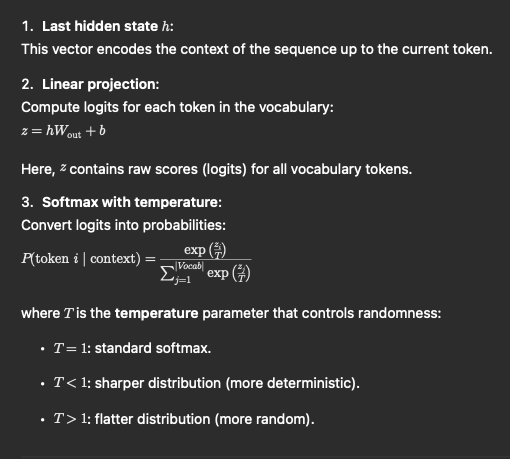

User can control the "smoothness" of the distribution by using a temperature parameter. A higher temperature will make the distribution more uniform, and a lower temperature will make it more concentrated on the highest probability tokens.

We do this by dividing the logits (the output of the linear transformation) by the temperature before applying the softmax. Since the exponentiation in the softmax has a large effect on larger numbers, making them all closer together will reduce this effect.


## final output

When we're stepping the model through time, we use the last column's probabilities to determine the next token to add to the sequence. For example, if we've supplied six tokens into the model, we'll use the output probabilities of the 6th column.

This column's output is a series of probabilities, and we actually have to pick one of them to use as the next in the sequence. 

Token Selection: The next token is chosen from this probability distribution using a sampling strategy. 

Common methods include:
- Greedy Sampling: Select the token with the highest probability. This is deterministic but may lead to repetitive or less creative outputs.

- Top-k Sampling: Sample from the top k  tokens with the highest probabilities. The probabilities are renormalized over these $ k $ tokens, and one is chosen randomly.

- Top-p (Nucleus) Sampling: Sample from the smallest set of tokens whose cumulative probability exceeds  p . This focuses on a dynamic "nucleus" of high-probability tokens.

- Temperature Sampling: Adjust the logits before softmax by dividing them by a temperature parameter T . Lower T < 1  sharpens the distribution (favoring high-probability tokens), while higher T > 1  flattens it (increasing randomness).

- Random Sampling: Sample directly from the full probability distribution, allowing any token to be chosen based on its probability.

Usally temperature sampling is used with other sampling methods except with greedy sampling.



#### Transformation of input



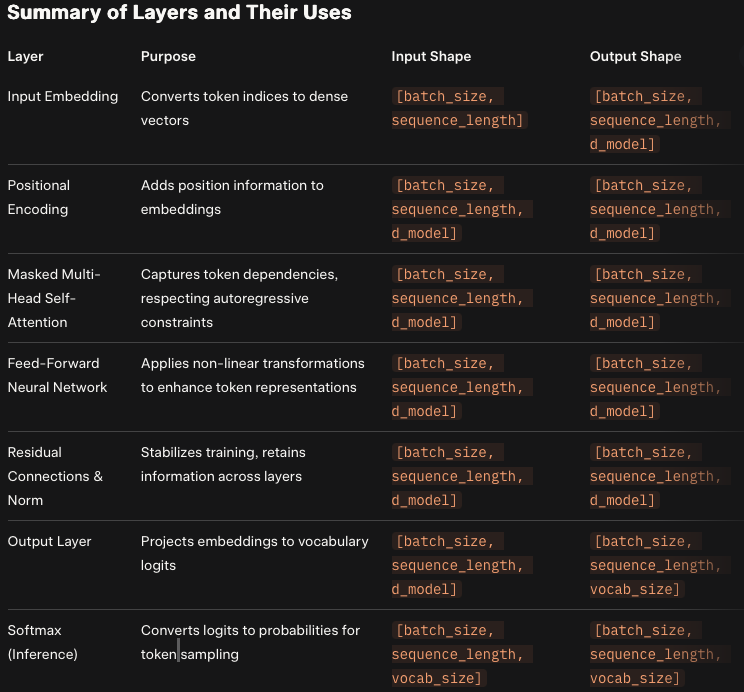
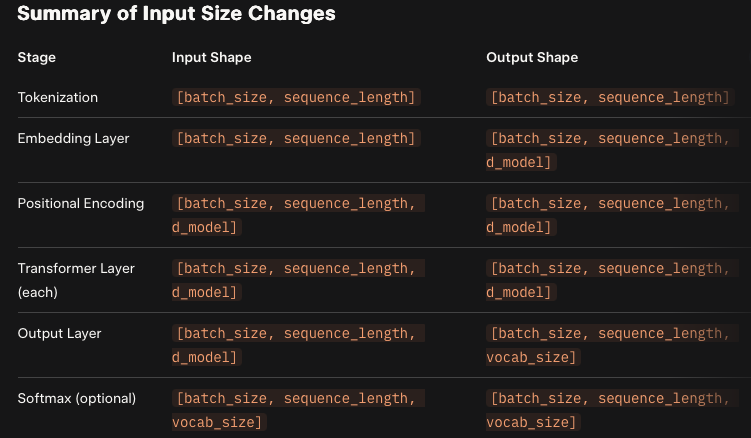